In [25]:
import torch_geometric
from torch_geometric.datasets import Planetoid

In [26]:
dataset=Planetoid(root='/tmp/Cora', name='Cora')
print(dataset)

Cora()


In [27]:
print("no of graphs:", len(dataset))
print("num features:", dataset.num_features)
print("num classes:", dataset.num_classes)
print("num of edges:", dataset[0].num_edges)
print("num of edge features:", dataset.num_edge_features)

no of graphs: 1
num features: 1433
num classes: 7
num of edges: 10556
num of edge features: 0


In [28]:
print("edge_index:", dataset.data.edge_index.shape)
print("x:", dataset.data.x.shape)
print("y:", dataset.data.y.shape)
print("train_mask:", dataset.data.train_mask.shape)
print("val_mask:", dataset.data.val_mask.shape)
print("test_mask:", dataset.data.test_mask.shape)
print("num nodes:", dataset.data.num_nodes)

edge_index: torch.Size([2, 10556])
x: torch.Size([2708, 1433])
y: torch.Size([2708])
train_mask: torch.Size([2708])
val_mask: torch.Size([2708])
test_mask: torch.Size([2708])
num nodes: 2708


/tmp/ipykernel_16973/792315066.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  print("edge_index:", dataset.data.edge_index.shape)
/tmp/ipykernel_16973/792315066.py:2: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  print("x:", dataset.data.x.shape)
/tmp/ipykernel_16973/792315066.py:3: UserWarning: It is not recommended to directly access the internal storage format `data

In [29]:
print(dataset.data.edge_index)

tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])


/tmp/ipykernel_16973/135294416.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  print(dataset.data.edge_index)


In [30]:
import os.path as osp
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

In [31]:
data=dataset[0]  # Get the first graph object.

In [32]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv(dataset.num_features, 64, aggr='max')
        self.conv2 = SAGEConv(64, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [37]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model,data=Net().to(device),data.to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [38]:
def train():
    model.train()
    optimizer.zero_grad()

    out = model(data)   # ✅ pass data
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()
    return loss.item()


In [39]:
@torch.no_grad()
def test():
    model.eval()
    logits = model(data)   # ✅ pass data

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].argmax(dim=1)
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)

    return accs

In [40]:
best_val_acc = test_acc = 0
for epoch in range(1, 501):
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, '
              f'Test Acc: {tmp_test_acc:.4f}')

Epoch: 010, Loss: 0.0161, Train Acc: 1.0000, Val Acc: 0.7740, Test Acc: 0.7740
Epoch: 020, Loss: 0.0039, Train Acc: 1.0000, Val Acc: 0.7020, Test Acc: 0.7220
Epoch: 030, Loss: 0.0019, Train Acc: 1.0000, Val Acc: 0.7380, Test Acc: 0.7520
Epoch: 040, Loss: 0.0018, Train Acc: 1.0000, Val Acc: 0.7480, Test Acc: 0.7580
Epoch: 050, Loss: 0.0281, Train Acc: 1.0000, Val Acc: 0.7660, Test Acc: 0.7650
Epoch: 060, Loss: 0.0071, Train Acc: 1.0000, Val Acc: 0.6640, Test Acc: 0.6880
Epoch: 070, Loss: 0.0332, Train Acc: 1.0000, Val Acc: 0.7360, Test Acc: 0.7840
Epoch: 080, Loss: 0.0124, Train Acc: 1.0000, Val Acc: 0.7000, Test Acc: 0.7250
Epoch: 090, Loss: 0.0048, Train Acc: 1.0000, Val Acc: 0.7380, Test Acc: 0.7830
Epoch: 100, Loss: 0.0016, Train Acc: 1.0000, Val Acc: 0.7420, Test Acc: 0.7650
Epoch: 110, Loss: 0.0032, Train Acc: 1.0000, Val Acc: 0.7420, Test Acc: 0.7570
Epoch: 120, Loss: 0.0031, Train Acc: 1.0000, Val Acc: 0.7680, Test Acc: 0.7750
Epoch: 130, Loss: 0.0038, Train Acc: 1.0000, Val Acc

In [41]:
model.eval()
with torch.no_grad():
    embeddings = model.conv1(data.x, data.edge_index)

In [42]:
print("Embedding shape:", embeddings.shape)

Embedding shape: torch.Size([2708, 64])


In [43]:
for i in range(5):
    print(f"Node {i} embedding:\n", embeddings[i])

Node 0 embedding:
 tensor([ 1.0275, -1.6566, -0.0182, -0.1593,  0.5819, -1.6516, -0.1915,  1.2717,
         0.1327,  0.1645, -0.0935,  2.1993,  1.2557,  0.8418,  0.4987,  0.1378,
         1.0290,  0.5019, -0.2989,  0.8246,  0.3055,  1.5415,  1.8717,  0.7517,
        -1.0602, -0.4758, -0.3229,  0.3164,  0.2892, -0.8705,  0.1746,  0.1573,
         0.1147, -0.2692,  1.0611,  1.7759,  0.8224,  0.4191, -1.1357,  1.1061,
         0.8039, -0.0269,  1.1986,  0.5569,  1.1455,  1.0672,  0.6200, -1.0892,
         0.7683,  0.2531,  0.7587, -0.0642, -0.2336,  1.0410, -1.3785,  0.3869,
        -0.0667, -1.8421,  0.0565, -1.1389,  0.7646,  0.5432,  0.2270,  1.0779],
       device='cuda:0')
Node 1 embedding:
 tensor([ 1.1627e+00, -7.6811e-02,  1.6854e+00, -1.0620e+00,  5.8058e-01,
        -1.2380e+00,  2.4698e+00,  2.8713e-01, -7.3819e-01,  1.1338e+00,
         1.4336e+00,  1.9583e-01,  7.9391e-01,  1.0296e-01, -1.1262e+00,
         1.3804e+00,  2.0931e+00, -1.3223e+00, -2.9471e-01,  1.1326e+00,
     

In [44]:
model.eval()
with torch.no_grad():
    embeddings = model.conv1(data.x, data.edge_index)

embeddings = embeddings.cpu().numpy()
labels = data.y.cpu().numpy()


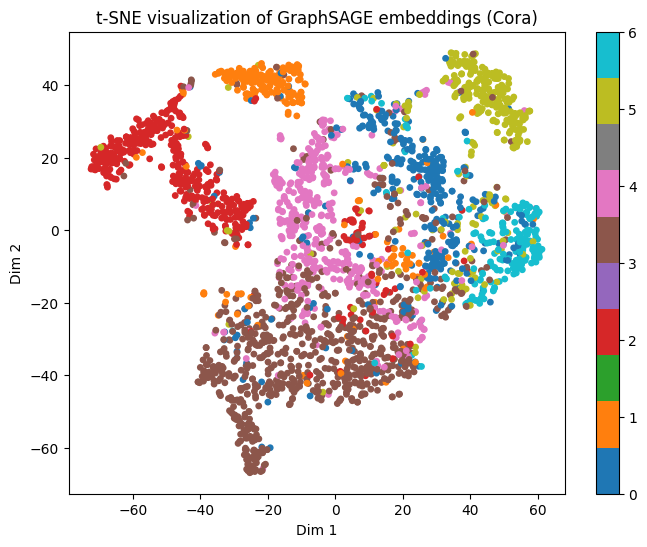

In [46]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,   # ✅ renamed
    random_state=42
)

emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=labels,
    cmap='tab10',
    s=15
)
plt.colorbar(scatter)
plt.title("t-SNE visualization of GraphSAGE embeddings (Cora)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()
